In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here

# import matplotlib
import matplotlib.pyplot as plt

import datetime
import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
import vision_pipeline.obb
import imagesize
import skimage
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from rich import print
from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle
# local imports
from vision_pipeline.helpers import Struct, make_valid_poly, img_to_camera_coords, scale_img, add_angles, load_depth_data_from_filename, robust_minimum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
base_path = Path("~/vision_pipeline/saves/2024-08-13_14:08:05_realsense_red_dot").expanduser()
img_path = Path("00033333333.jpg")

depth_rescaling_factor = 1/1000

colour_img, depth_vis_img, depth_img, camera_info = load_depth_data_from_filename(img_path.stem, base_path, 1)

camera_calib_path = Path("~/vision_pipeline/saves/2024-07-30_09:47:16_realsense_calibration/camera_calibration.json").expanduser()
camera_calib = None
with open(camera_calib_path) as f:
    camera_calib = json.load(f)
    print(camera_calib)
    camera_mtx = np.array(camera_calib["mtx"])
    camera_dist = np.array(camera_calib["dist"])
    print("camera_mtx.shape", camera_mtx.shape)
    print(camera_mtx)
    print("camera_dist.shape", camera_dist.shape)
    print(camera_dist)


print("depth_img", np.min(depth_img), np.max(depth_img))
plt.hist(depth_img.flatten(), bins=1000)
plt.show()

#! Apply undistortion
h, w = colour_img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_mtx, camera_dist, (w, h), 1, (w, h))
colour_img = cv2.undistort(colour_img, camera_mtx, camera_dist, None, newcameramtx)
depth_img = cv2.undistort(depth_img, camera_mtx, camera_dist, None, newcameramtx)

camera_info.K = newcameramtx.flatten() #! IMPORTANT. Use new K for the camera_info that is used for the deproject


#! END

# min_val = np.min(depth_img)
# max_val = np.max(depth_img)

# # Normalize the depth values to the range 0-255
# normalized_depth = cv2.normalize(depth_img, None, 0, 255, cv2.NORM_MINMAX)
# normalized_depth = np.uint8(normalized_depth)


# normalized_depth_undistort = cv2.undistort(normalized_depth, camera_mtx, camera_dist, None, newcameramtx)


# # Undo the normalization
# # Convert the 8-bit values back to the original range
# restored_depth_image = normalized_depth_undistort * (max_val - min_val) / 255 + min_val

# # Ensure the restored depth image has the same type as the original depth image
# restored_depth_image = restored_depth_image.astype(depth_img.dtype)

# depth_img = restored_depth_image

#! what if we do the rescaling after the undistort?
depth_img = depth_img * depth_rescaling_factor


print("colour_img.shape", colour_img.shape)
print("depth_img.shape", depth_img.shape)

              
print("depth_img", np.min(depth_img), np.max(depth_img))
plt.hist(depth_img.flatten(), bins=1000)
plt.show()
                        

display(PILImage.fromarray(scale_img(cv2.cvtColor(colour_img, cv2.COLOR_BGR2RGB))))


[ WARN:0@3982.108] global loadsave.cpp:248 findDecoder imread_('/home/docker/vision_pipeline/saves/2024-08-13_14:08:05_realsense_red_dot/00033333333.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3982.108] global loadsave.cpp:248 findDecoder imread_('/home/docker/vision_pipeline/saves/2024-08-13_14:08:05_realsense_red_dot/00033333333_depth_viz.jpg'): can't open/read file: check file path/integrity


FileNotFoundError: [Errno 2] No such file or directory: '/home/docker/vision_pipeline/saves/2024-08-13_14:08:05_realsense_red_dot/00033333333_depth.npy'

dot_coord_px [817 631]

dot_coord_px [954 594]

dot_coord_px [1102  557]

dot_coord_px [773 496]

dot_coord_px [902 457]

dot_coord_px [1045  414]

dot_coord_px [734 371]

dot_coord_px [858 328]

dot_coord_px [319 288]

dot_coord_px [992 281]

dot_coord_px [77 88]

dot_coord_px [226  61]

dot_coord_px [235  48]

dot_coord_px [41 30]

dot_coord_px [279  18]

dot_coord_px [40 19]

dot_coord_px [288  19]

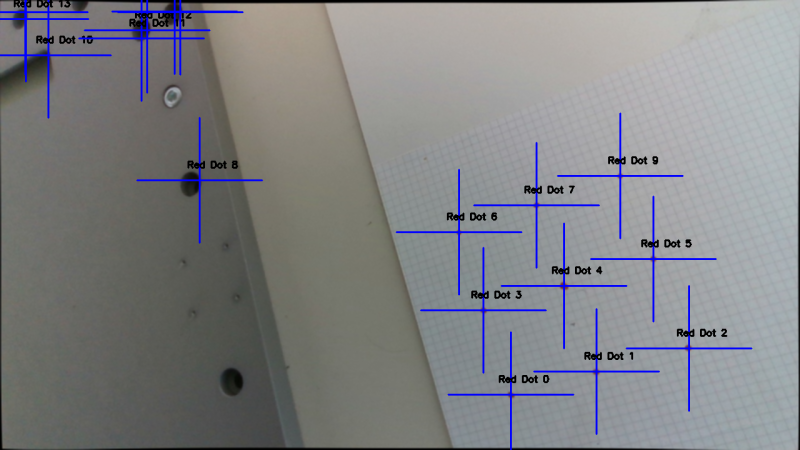

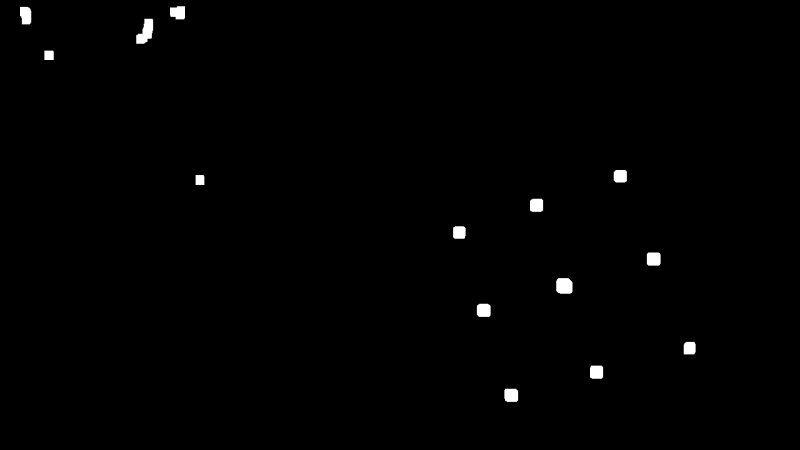

In [ ]:
painted_img = colour_img.copy()
img_height, img_width = colour_img.shape[:2]

kernel = (3, 3)
painted_img = cv2.blur(painted_img, kernel)

# Convert the image to the HSV color space
hsv_image = cv2.cvtColor(painted_img, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# These values might need adjustment depending on the exact shade of red
# lower_red = np.array([0, 100, 100])
# upper_red = np.array([10, 255, 255])

# # Create a mask for the red color
# mask = cv2.inRange(hsv_image, lower_red, upper_red)

## Gen lower mask (0-5) and upper mask (175-180) of RED
mask1 = cv2.inRange(hsv_image, (0,50,20), (5,255,255))
mask2 = cv2.inRange(hsv_image, (175,50,20), (180,255,255))

## Merge the mask and crop the red regions
mask = cv2.bitwise_or(mask1, mask2)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) == 0:
    print("error! no dot!")

dot_contours = []
dot_coord_pxs = []
depth_masks = []
count = 0
all_depth_mask = np.zeros_like(mask)
# Draw the contours and locate the red dot
for idx, contour in enumerate(contours):
    # Get the moments to calculate the center of the contour
    M = cv2.moments(contour)
    
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        coord_px = np.array([cX, cY])

        threshold_px_to_border = 10

        if (cX > threshold_px_to_border and cX < img_width - threshold_px_to_border and
        cY > threshold_px_to_border and cY < img_height - threshold_px_to_border):

            dot_coord_pxs.append(coord_px)
            print("dot_coord_px", coord_px)
            
            dot_contours.append(contour)
            # print("dot_contour", dot_contour)
            # Draw the contour and center of the red dot
            # cv2.drawContours(colour_img, [contour], -1, (0, 255, 0), 2)
            # cv2.circle(colour_img, (cX, cY), 7, (255, 0, 0), -1)
            cross_size = 100
            cv2.line(painted_img, (cX - cross_size, cY), (cX + cross_size, cY), (255, 0, 0), 2)
            cv2.line(painted_img, (cX, cY - cross_size), (cX, cY + cross_size), (255, 0, 0), 2)

            cv2.putText(painted_img, f"Red Dot {count}", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
            depth_mask = np.zeros_like(mask)
            cv2.drawContours(depth_mask, [contour], -1, (255), thickness=cv2.FILLED)

            kernel_dilate = np.ones((5, 5), np.uint8)
            depth_mask = cv2.dilate(depth_mask, kernel_dilate, iterations=3)
            all_depth_mask = cv2.bitwise_or(all_depth_mask, depth_mask)
            
            depth_masks.append(depth_mask)

            count += 1

# mask = np.zeros(painted_img.shape[:2])
# print("mask", mask.shape)
# mask = np.array(cv2.drawContours(mask, [dot_contour], 0, (1), thickness=cv2.FILLED), dtype=np.uint8)
# print("mask", mask.shape)

# kernel = np.ones((3, 3), np.uint8)
# mask = cv2.dilate(mask, kernel, iterations=3)



display(PILImage.fromarray(scale_img(cv2.cvtColor(painted_img, cv2.COLOR_BGR2RGB))))
display(PILImage.fromarray(scale_img(cv2.cvtColor(all_depth_mask, cv2.COLOR_BGR2RGB))))

# not working:
# points_for_undistort = np.array([[dot_coord_px]])
# print("points_for_undistort.shape", points_for_undistort.shape)
# xn_u = cv2.undistortPoints(points_for_undistort, camera_mtx, camera_dist, None, None)[:, 0].T

# print("xn_u", xn_u)

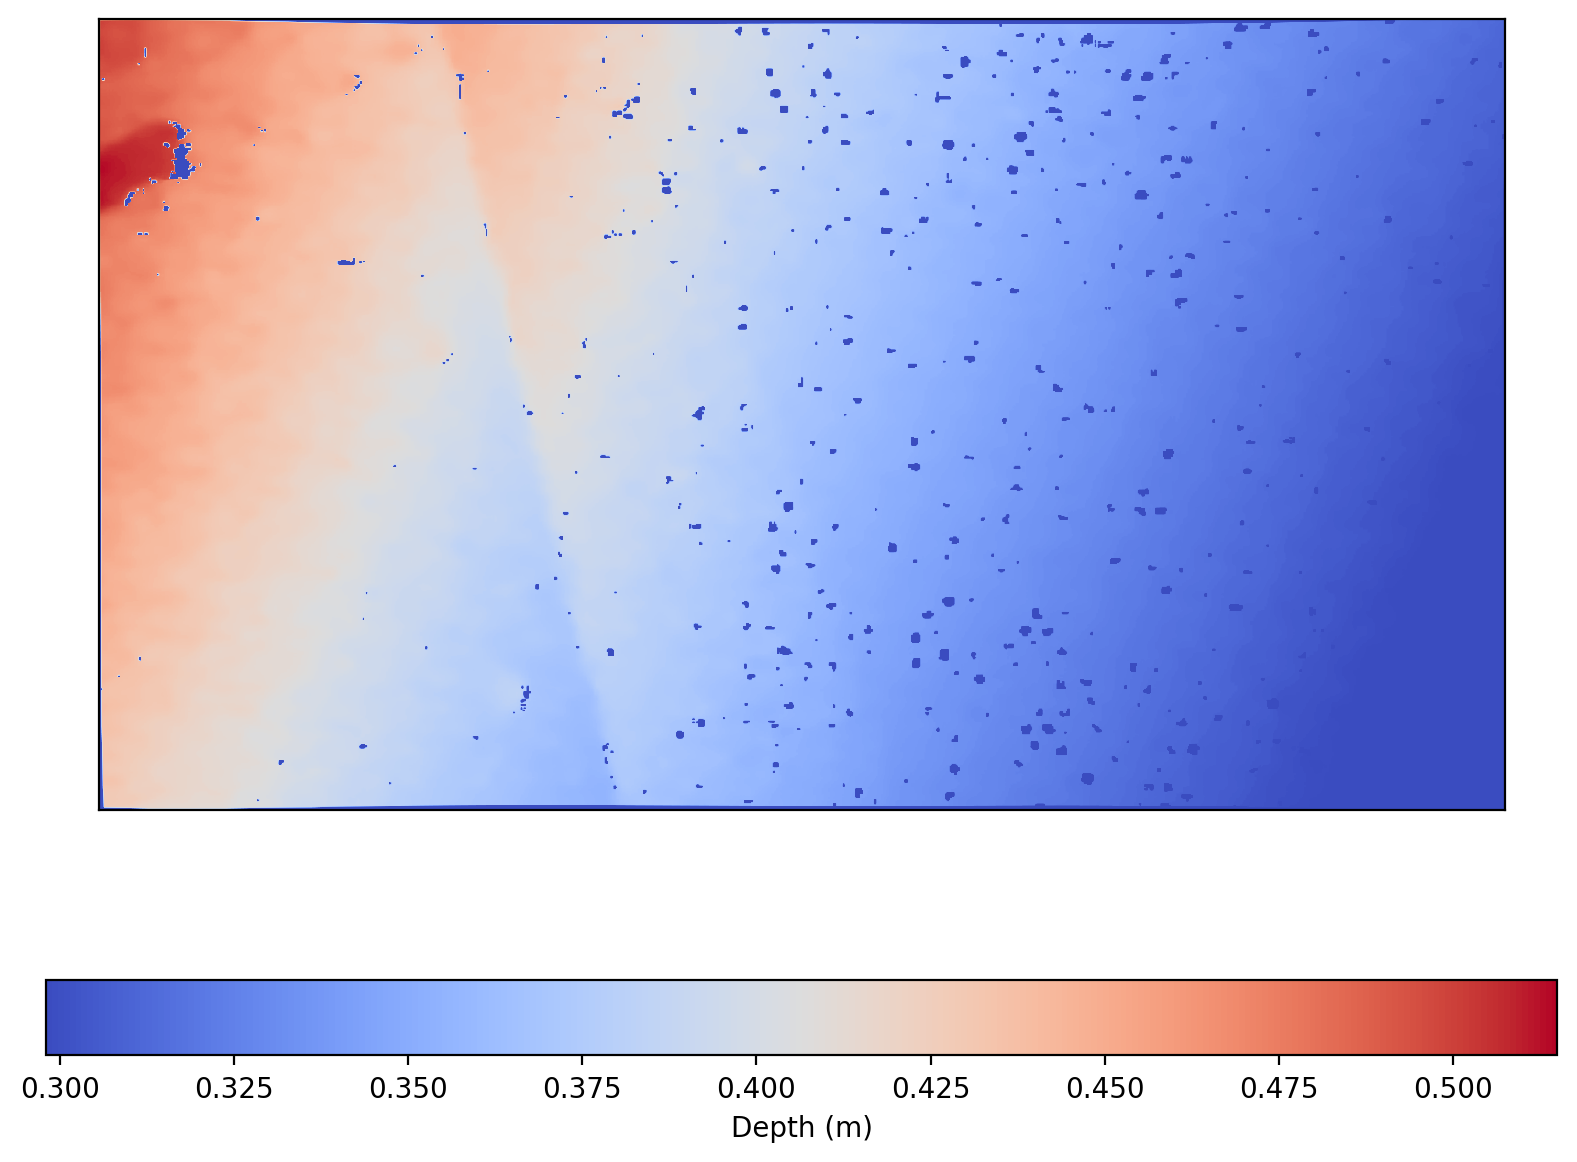

depth_robust_min 0.329

median 0.33

depth_robust_min 0.316

median 0.317

depth_robust_min 0.304

median 0.304

depth_robust_min 0.341

median 0.342

depth_robust_min 0.329

median 0.33

depth_robust_min 0.315

median 0.316

depth_robust_min 0.353

median 0.354

depth_robust_min 0.341

median 0.342

depth_robust_min 0.403

median 0.406

depth_robust_min 0.326

median 0.328

depth_robust_min 0.47100000000000003

median 0.47300000000000003

depth_robust_min 0.441

median 0.448

depth_robust_min 0.438

median 0.44

depth_robust_min 0.482

median 0.488

depth_robust_min 0.436

median 0.441

depth_robust_min 0.487

median 0.491

depth_robust_min 0.432

median 0.436

In [ ]:
def robust_depth_min_from_mask(depth_img, mask):
    depth_masked = cv2.bitwise_and(depth_img, depth_img, mask=mask)
    depth_masked_np = np.ma.masked_equal(depth_masked, 0.0, copy=False)
    compressed_depth = depth_masked_np.compressed()
    depth_robust_min, median = None, None
    if len(compressed_depth) > 0:
        
        depth_robust_min = robust_minimum(compressed_depth)
        median = np.median(compressed_depth)
    else:
        print(f"no depth info! {np.min(depth_masked)} {np.max(depth_masked)}")
        # display(PILImage.fromarray(depth_masked))
        plt_im = plt.imshow(depth_masked, cmap='coolwarm')
        # plt.colorbar(plt_im, label="Depth (m)", orientation='horizontal')
        plt.show()


    # print("depth_robust_min", depth_robust_min)
    # print("min", depth_masked_np.min())
    return depth_robust_min, median, depth_masked


def plot_depth(depth_img):
    depth_min_nonzero = np.min(depth_img[np.nonzero(depth_img)])
    
    # set robust_minimum with trim of .5% for a bit more leeway
    depth_robust_min = robust_minimum(depth_img[np.nonzero(depth_img)], 0.05) 

    depth_max = np.max(depth_img)
    # print("depth_robust_min", depth_robust_min)
    # print("depth_min_nonzero", depth_min_nonzero)
    # print("depth_max", depth_max)

    fig = plt.figure(figsize=(8, 6), dpi=200)
    plt_im = plt.imshow(depth_img, vmin=depth_robust_min, vmax=depth_max, cmap='coolwarm')
    plt.colorbar(plt_im, label="Depth (m)", orientation='horizontal')
    save_path = base_path / Path(img_path.stem + '_depth_vis_matplotlib.png')
    
    plt.xticks([], [])
    plt.yticks([], [])
    fig.tight_layout()
    plt.savefig(save_path)
    plt.show()

plot_depth(depth_img)

robust_mins = []
medians = []
for depth_mask in depth_masks:
    depth_robust_min, median, depth_masked = robust_depth_min_from_mask(depth_img, depth_mask)
    robust_mins.append(depth_robust_min)
    medians.append(median)
    print("depth_robust_min", depth_robust_min)
    print("median", median)
    # plot_depth(depth_masked)


world_coords
 [[ 0.05956539  0.10432663  0.33000001]
 [ 0.1046178   0.08741185  0.317     ]
 [ 0.14943229  0.07154731  0.30399999]
 [ 0.04530784  0.05771499  0.34200001]
 [ 0.0901795   0.04163929  0.33000001]
 [ 0.13567242  0.02503831  0.31600001]
 [ 0.03182955  0.01143088  0.354     ]
 [ 0.07703518 -0.00501164  0.34200001]
 [-0.14738691 -0.02367923  0.40599999]
 [ 0.12185143 -0.02163664  0.32800001]
 [-0.29663897 -0.13086486  0.47299999]
 [-0.20810644 -0.13715371  0.44800001]
 [-0.20006827 -0.14094925  0.44      ]
 [-0.32522002 -0.16591533  0.48800001]
 [-0.17934519 -0.15571323  0.44100001]
 [-0.32775521 -0.17283174  0.491     ]
 [-0.17302909 -0.15347177  0.43599999]]

/home/docker/vision_pipeline/saves/2024-08-13_14:08:05_realsense_red_dot/0009_3d_deproject.png

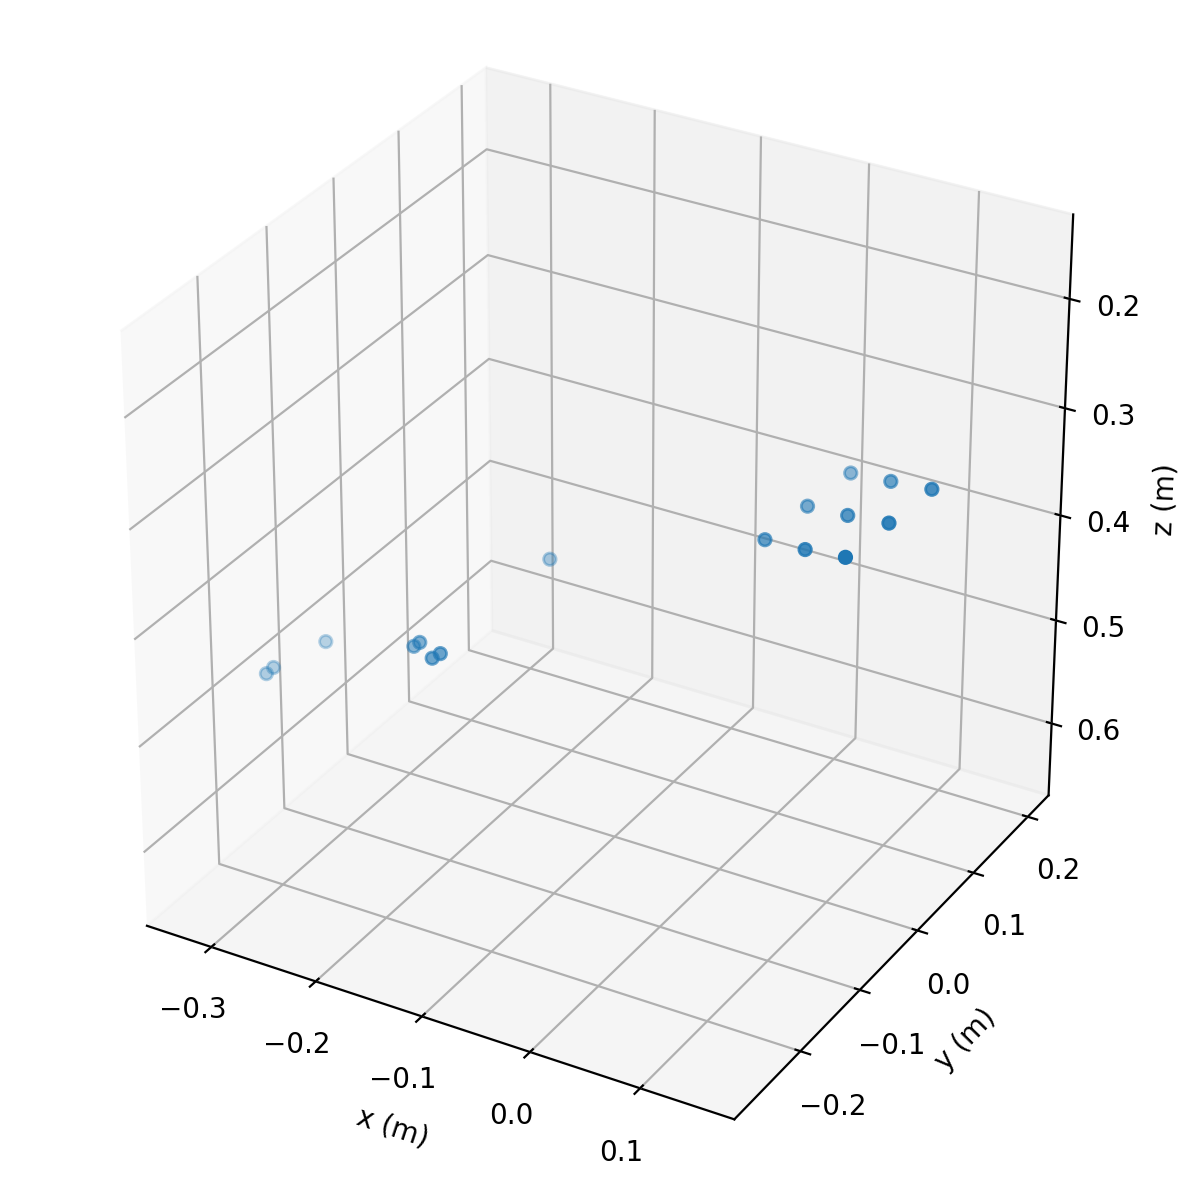

In [ ]:
world_coords = []
for coord_px, robust_min, median in zip(dot_coord_pxs, robust_mins, medians):
    #! choice of robust_min or median. Median is better.
    if median is not None:
        world_coord = img_to_camera_coords(coord_px, median, camera_info)
        world_coords.append(world_coord)
    # else:
        # world_coords.append(None)

world_coords = np.array(world_coords)
print("world_coords\n", world_coords)

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
X, Y, Z = world_coords[:, 0], world_coords[:, 1], world_coords[:, 2]
ax.scatter(X, Y, Z, marker='o')

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

ax.invert_zaxis()

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
fig.tight_layout()
plt.grid()

save_path = base_path / Path(img_path.stem + '_3d_deproject.png')
print(save_path)
plt.savefig(save_path)
plt.show()

# plt.scatter(world_coords[:, 0], world_coords[:, 1], c ="blue")
# plt.show()

In [ ]:
from scipy.spatial import distance_matrix

# Calculate the pairwise distance matrix
distances = distance_matrix(world_coords, world_coords)

# Set the diagonal to a large number to ignore self-distances
np.fill_diagonal(distances, np.inf)

# # Extract the upper triangle of the distance matrix (excluding diagonal)
pairwise_distances = distances[np.triu_indices_from(distances, k=1)]

# threshold between 3cm and 6cm to exclude diagonal pairs
pairwise_distances = [d for d in pairwise_distances if d < 0.060 and d > 0.03]

print("pairwise_distances", pairwise_distances)

print("len(pairwise_distances)", len(pairwise_distances))

# # Calculate the standard deviation of these distances
std_dev = np.std(pairwise_distances)
mean = np.mean(pairwise_distances)

print(f"Standard Deviation of distances between dots: {(std_dev*1000):.2f} mm")
print(f"mean of distances between dots: {(mean*1000):.2f} mm")

pairwise_distances
[
    0.0498480614520812,
    0.05019883218857131,
    0.049285112353762844,
    0.04972515992985328,
    0.04996420782848819,
    0.049151746095117,
    0.049677788632111836,
    0.050410298451511515,
    0.0499307761247492,
    0.05013552427468121,
    0.049577265241639426,
    0.04980850215706846,
    0.047648843316686645,
    0.05525794551801517,
    0.03493802033708208,
    0.04050555276704194,
    0.030065433082513384
]

len(pairwise_distances) 17

Standard Deviation of distances between dots: 6.12 mm

mean of distances between dots: 47.42 mm

In [77]:
# img 0001: 

# Standard Deviation of distances between dots: 0.38 mm
# mean of distances between dots: 49.87 mm

# img 0002: 

# Standard Deviation of distances between dots: 0.42 mm
# mean of distances between dots: 49.85 mm

# img 0003:

# Standard Deviation of distances between dots: 0.50 mm
# mean of distances between dots: 50.03 mm

# img 0004: 

# Standard Deviation of distances between dots: 0.44 mm
# mean of distances between dots: 49.87 mm

# img 0005:

# Standard Deviation of distances between dots: 0.43 mm
# mean of distances between dots: 49.78 mm


# img 0006:

# Standard Deviation of distances between dots: 0.41 mm
# mean of distances between dots: 49.86 mm

# img 0007:

# Standard Deviation of distances between dots: 0.33 mm
# mean of distances between dots: 49.90 mm

# img 0008:

# Standard Deviation of distances between dots: 0.47 mm
# mean of distances between dots: 50.10 mm

mean = np.mean([49.87, 49.85, 50.03, 49.87, 49.78, 49.86, 49.90, 50.10])
print("mean", mean)

std = np.mean([0.38,0.42, 0.50, 0.44, 0.43, 0.41, 0.33, 0.47])
print("std", std)


mean 49.9075

std 0.4225